<a href="https://colab.research.google.com/github/zhangxs131/garbage/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#词向量的使用
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F

torch.manual_seed(1)
embed=nn.Embedding(2,5)
vocab={'hello':0,'world':1}
input_tensor=torch.LongTensor([vocab['hello'],vocab['world']])
embedding=embed(autograd.Variable(input_tensor))
print(embedding)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519],
        [-0.1661, -1.5228,  0.3817, -1.0276, -0.5631]],
       grad_fn=<EmbeddingBackward0>)


[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall')]


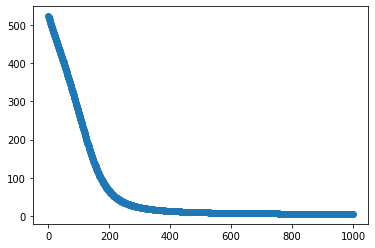

In [ ]:
# Ngram 实现，这里tri-gram，即使用i-2,i-1来预测i
import matplotlib.pyplot as plt

context_size=2
embedding_dim=10
sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()

tri_grams=[([sentence[i],sentence[i+1]],sentence[i+2]) for i in range(len(sentence)-2)]

print(tri_grams[:2])

vocab=set(sentence)
word_to_idx={word:i for i ,word in enumerate(vocab)}


class NgramModel(nn.Module):
  def __init__(self,vocab_size,context_size,embedding_dim):
    super().__init__()
    self.embedding=nn.Embedding(vocab_size,embedding_dim)
    self.fc1=nn.Linear(context_size*embedding_dim,128)
    self.fc2=nn.Linear(128,vocab_size)

  def forward(self,x):
    x=self.embedding(x).view(1,-1)
    x=F.relu(self.fc1(x))
    x=self.fc2(x)
    output=F.log_softmax(x,dim=1)
    return output

#定义模型，损失，优化器
losses=[]
loss_func=nn.NLLLoss()
model=NgramModel(len(vocab),context_size,embedding_dim)
optimizer=torch.optim.SGD(model.parameters(),lr=0.001)

for epoch in range(1000):
  total_loss=torch.Tensor([0])
  for data,target in tri_grams:

    idx=[word_to_idx[i] for i in data]
    var=autograd.Variable(torch.LongTensor(idx))

    model.zero_grad()
    output=model(var)

    loss=loss_func(output,autograd.Variable(torch.LongTensor([word_to_idx[target]])))

    loss.backward()
    optimizer.step()

    total_loss+=loss.data
  losses.append(total_loss.numpy()[0])


x=[i for i in range(len(losses))]
plt.scatter(x,losses)
plt.show()

#CBOW连续词袋模型

这里的语言模型与Ngrams类似，不过是从i-2,i-1预测i，改为了，使用i-2,i-1,i+1,i+2预测i，通过上下词来预测中间词的思想

[(['When', 'forty', 'shall', 'besiege'], 'winters'), (['forty', 'winters', 'besiege', 'thy'], 'shall')]


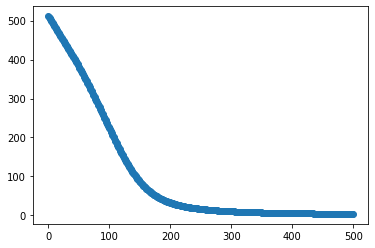

In [ ]:
context_size=2
embedding_dim=10
sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()

tri_grams=[([sentence[i-2],sentence[i-1],sentence[i+1],sentence[i+2]],sentence[i]) for i in range(2,len(sentence)-2)]

print(tri_grams[:2])

vocab=set(sentence)
word_to_idx={word:i for i ,word in enumerate(vocab)}


class CBOWModel(nn.Module):
  def __init__(self,vocab_size,context_size,embedding_dim):
    super().__init__()
    self.embedding=nn.Embedding(vocab_size,embedding_dim)
    self.fc1=nn.Linear(2*context_size*embedding_dim,128)
    self.fc2=nn.Linear(128,vocab_size)

  def forward(self,x):
    x=self.embedding(x).view(1,-1)
    x=F.relu(self.fc1(x))
    x=self.fc2(x)
    output=F.log_softmax(x,dim=1)
    return output

#定义模型，损失，优化器
losses=[]
loss_func=nn.NLLLoss()
model=CBOWModel(len(vocab),context_size,embedding_dim)
optimizer=torch.optim.SGD(model.parameters(),lr=0.001)

for epoch in range(500):
  total_loss=torch.Tensor([0])
  for data,target in tri_grams:

    idx=[word_to_idx[i] for i in data]
    var=autograd.Variable(torch.LongTensor(idx))

    model.zero_grad()
    output=model(var)

    loss=loss_func(output,autograd.Variable(torch.LongTensor([word_to_idx[target]])))

    loss.backward()
    optimizer.step()

    total_loss+=loss.data
  losses.append(total_loss.numpy()[0])


x=[i for i in range(len(losses))]
plt.scatter(x,losses)
plt.show()

#skip-gram
这个语言模型与CBow相反是使用，这里不同的是分别计算i预测i-2,i-1,i+1,i+2,四个的损失进行训练还是一起计算四个平均值进行训练好呢。

[(['When', 'forty', 'shall', 'besiege'], 'winters'), (['forty', 'winters', 'besiege', 'thy'], 'shall')]
[['winters', 'When'], ['winters', 'forty'], ['winters', 'shall'], ['winters', 'besiege']]


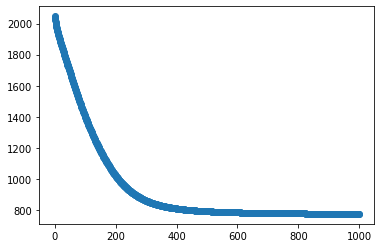

In [21]:
context_size=2
embedding_dim=10
sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()

tri_grams=[([sentence[i-2],sentence[i-1],sentence[i+1],sentence[i+2]],sentence[i]) for i in range(2,len(sentence)-2)]

train_data=[]
for target,data in tri_grams:
  for j in target:
    train_data.append([data,j])


print(tri_grams[:2])
print(train_data[:4])

vocab=set(sentence)
word_to_idx={word:i for i ,word in enumerate(vocab)}


class SkipGramModel(nn.Module):
  def __init__(self,vocab_size,context_size,embedding_dim):
    super().__init__()
    self.embedding=nn.Embedding(vocab_size,embedding_dim)
    self.fc1=nn.Linear(embedding_dim,128)
    self.fc2=nn.Linear(128,vocab_size)

  def forward(self,x):
    x=self.embedding(x).view(1,-1)
    x=F.relu(self.fc1(x))
    x=self.fc2(x)
    output=F.log_softmax(x,dim=1)
    return output

#定义模型，损失，优化器
losses=[]
loss_func=nn.NLLLoss()
model=SkipGramModel(len(vocab),context_size,embedding_dim)
optimizer=torch.optim.SGD(model.parameters(),lr=0.001)

for epoch in range(1000):
  total_loss=torch.Tensor([0])
  for data,target in train_data:

    idx=[word_to_idx[data]]
    var=autograd.Variable(torch.LongTensor(idx))

    model.zero_grad()
    output=model(var)

    loss=loss_func(output,autograd.Variable(torch.LongTensor([word_to_idx[target]])))

    loss.backward()
    optimizer.step()

    total_loss+=loss.data
  losses.append(total_loss.numpy()[0])


x=[i for i in range(len(losses))]
plt.scatter(x,losses)
plt.show()